In [76]:
import dill
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tqdm
from keras.layers import Embedding
import numpy as np

In [5]:
#model_file = open("/home/alekspet/Projects/aprec/aprec/evaluation/results/ml_benchmark20m_sasrec_variable_importance_2022_11_04T09_03_25/checkpoints/SASRec-vanilla.dill", "rb")
#model_file = open("/home/alekspet/Projects/aprec/aprec/evaluation/results/ml_benchmark20m_sasrec_variable_importance_2022_11_04T09_03_25/checkpoints/Sasrec-rss-lambdarank-0.01.dill", "rb")
#model_file = open("/home/alekspet/Projects/aprec/aprec/evaluation/results/ml_benchmark20m_sasrec_variable_importance_2022_11_04T09_03_25/checkpoints/Sasrec-rss-lambdarank-0.5.dill", "rb")
#model_file = open("/home/alekspet/Projects/aprec/aprec/evaluation/results/ml_benchmark20m_sasrec_variable_importance_2022_11_04T09_03_25/checkpoints/Sasrec-rss-lambdarank-0.5.dill", "rb")#
model_file = open("/home/alekspet/Projects/aprec/aprec/evaluation/results/ml_benchmark20m_sasrec_variable_importance_2022_11_06T10_18_53/checkpoints/Sasrec-rss-lambdarank-0.5.dill", "rb")


In [6]:
recommender = dill.load(model_file)

In [7]:
user_ids = recommender.recommender.users.straight

In [8]:
sasrec_recommender = recommender.recommender

In [9]:
def get_attention_maps(user_id, sasrec_recommender):
    inputs = sasrec_recommender.get_model_inputs(user_id)[0]
    with tf.device('/cpu:0'):
        seq, attn = sasrec_recommender.model.get_seq_embedding(inputs)
    return attn[0][0].numpy()

In [10]:
m = get_attention_maps('28507', sasrec_recommender)

AttributeError: 'OwnSasrecModel' object has no attribute 'pos_embedding_comb'

In [ ]:
maps = []
for n in tqdm.tqdm(range(1000)):
    uid = np.random.choice(list(user_ids.keys()))
    maps.append(get_attention_maps(uid, sasrec_recommender))
    
    

In [9]:
mean_attentions = np.mean(maps, axis=0)

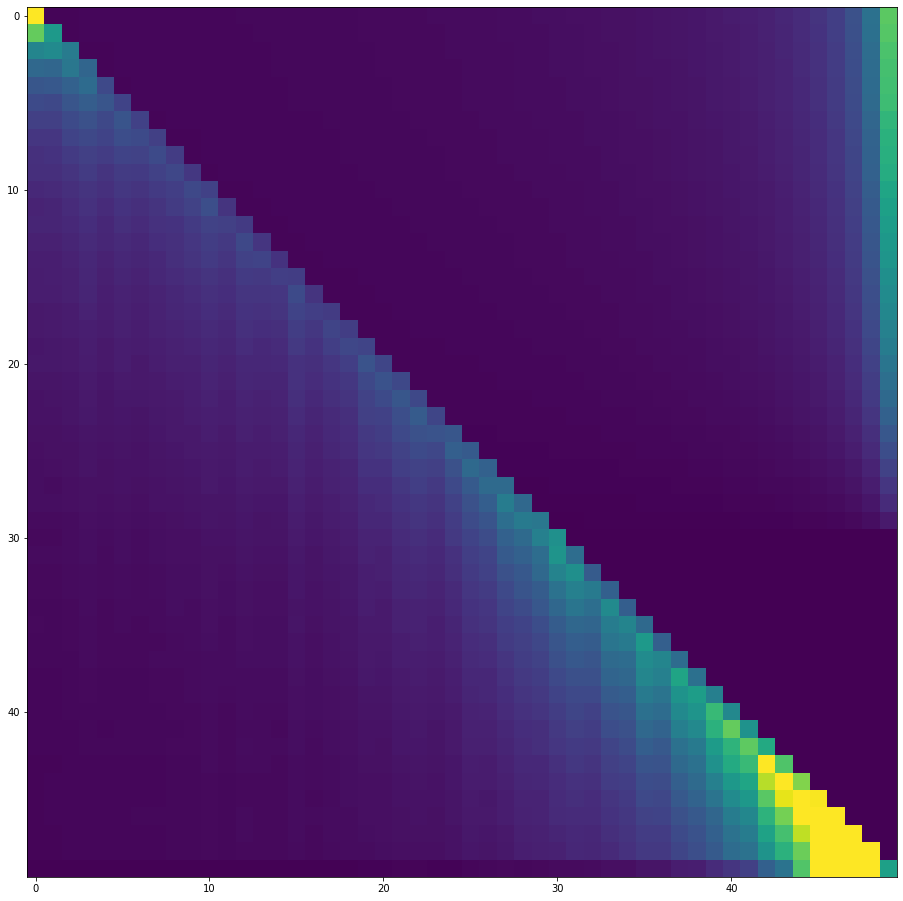

In [10]:
weights = np.expand_dims(np.arange(50, 0, -1), 0)
plt.figure(figsize=(16,16))
plt.imshow(mean_attentions/weights, vmax=0.01)

In [11]:
res = []
n = 49
a = 0.5
for i in range(n):
    res.append(a ** (n - i))
res = np.array(res) /np.sum(res)

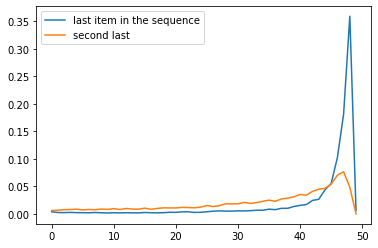

In [12]:
plt.plot(mean_attentions[49], label='last item in the sequence')
plt.plot(mean_attentions[48], label='second last')

#plt.plot(mean_attentions[24][:25], label='25th item in the sequence')
#plt.plot(res, label = 'position_importance')
plt.legend()

In [13]:
rss_weights = np.array([0.00050863, 0.00061887, 0.00092197, 0.0014479 , 0.00090583,
       0.00090679, 0.00081685, 0.00119046, 0.00088777, 0.00057822,
       0.00139008, 0.00110968, 0.00142508, 0.00104092, 0.00105084,
       0.00108611, 0.00110633, 0.00163135, 0.00142438, 0.0030446 ,
       0.00163955, 0.00301373, 0.00228171, 0.00208965, 0.00155316,
       0.00093835, 0.00178353, 0.0017377 , 0.00252213, 0.00173926,
       0.00320056, 0.00308274, 0.00458886, 0.0035606 , 0.0047561 ,
       0.00692631, 0.00971894, 0.0089213 , 0.01161868, 0.01065103,
       0.01554658, 0.0157064 , 0.02285646, 0.03320919, 0.04574714,
       0.06964114, 0.12280825, 0.20446777, 0.34794655, 0.01265421])

In [14]:
vanilla_weights = np.array([0.00723696, 0.00789131, 0.00889317, 0.00740616, 0.00823375,
       0.00879929, 0.00743264, 0.00758507, 0.00899467, 0.00783445,
       0.00634459, 0.00708402, 0.00703078, 0.00810132, 0.00828369,
       0.00845831, 0.00829117, 0.00793688, 0.00801629, 0.00869415,
       0.00855302, 0.01001667, 0.00904213, 0.00945777, 0.00892488,
       0.01191296, 0.01217955, 0.01356116, 0.01392799, 0.01479892,
       0.01614767, 0.01513599, 0.01697625, 0.01921821, 0.01820138,
       0.01843641, 0.02193111, 0.0230982 , 0.02433731, 0.02698987,
       0.02998334, 0.03684098, 0.03525388, 0.04003029, 0.04953673,
       0.050356  , 0.06957363, 0.07372294, 0.08696238, 0.05634372]
    )

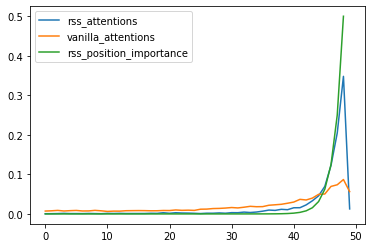

In [15]:
plt.plot(rss_weights, label='rss_attentions')
plt.plot(vanilla_weights, label='vanilla_attentions')
plt.plot(res, label  = 'rss_position_importance')
plt.legend()

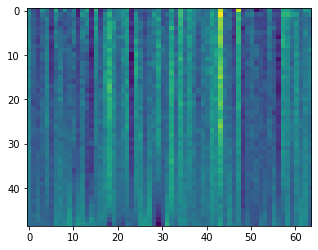

In [76]:
all_items = np.arange(49)
embs = recommender.recommender.model.postion_embedding_layer(all_items)
plt.imshow(embs)

In [11]:
def pos_sim(emb1, emb2):
    return np.linalg.norm(emb2 - emb1)

def sim_matr(embs):
    result = []
    for i in range(len(embs)):
        result.append([])
        emb1 = embs[i]
        for j in range(len(embs)):
            emb2 = embs[j]
            result[-1].append(pos_sim(emb1, emb2))
    return np.array(result)

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(sim_matr(embs))

NameError: name 'embs' is not defined

<Figure size 576x576 with 0 Axes>

In [21]:

    
class SinePositionEncoding(keras.layers.Layer):
    def __init__(
        self,
        seq_length, 
        hidden_size,
        max_wavelength=10000,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength
        self.seq_length = seq_length
        self.hidden_size = hidden_size
    
    def call(self, positions):
        seq_length = self.seq_length
        hidden_size = self.hidden_size
        position = tf.cast(tf.range(seq_length), self.compute_dtype)
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)
        sin_mask = 1 - cos_mask
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )
        return tf.gather(positional_encodings, positions)


In [61]:
class ExpPositionalEncoding(keras.layers.Layer):
    def __init__(self, seq_len, emb_size, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.emb_size = emb_size
        pows_initalizer = tf.random_uniform_initializer(-3, 3)
        self.pow = tf.Variable(initial_value=pows_initalizer(shape=(emb_size, )), trainable=True)
        
    
    def __call__(self, positions):
        w = tf.exp(self.pow)
        for i in range(len(positions.shape)):
            w = tf.expand_dims(w, 0)
        tiles = list(positions.shape) + [1]
        w = tf.tile(w, tiles)
        positions_norm = tf.cast((positions+1), 'float32')/(self.seq_len+1)
        pos = tf.tile(tf.expand_dims(positions_norm, -1), [1] * len(positions.shape) + [self.emb_size])
        return tf.pow(pos, w)

In [89]:
all_items = np.arange(49)

encoder = Embedding(49, 64)

In [90]:
more_items =tf.tile(tf.expand_dims(all_items, 0), [5, 1])

In [91]:
emb = encoder(more_items)


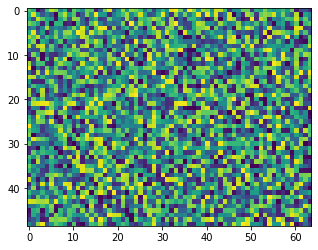

In [92]:
plt.imshow(emb[1])

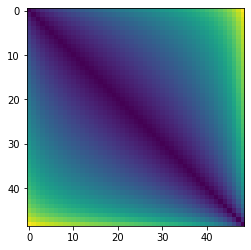

In [359]:
plt.imshow(sim_matr(emb))